In [ ]:
import pandas as pd
import tensorflow as tf
from keras import models
from keras import layers
import numpy as np
from keras.models import Sequential
from keras.utils import to_categorical

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, concatenate, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from glob import glob
from PIL import Image
import os
import numpy as np
from PIL import Image

# 이미지 파일들이 저장된 디렉토리 경로
directory_pattern = "/content/drive/MyDrive/딥실 데이터셋/archive/HAM10000_images_part_*"

# 디렉토리 패턴에 맞는 모든 파일 경로 가져오기
imgPath = {os.path.splitext(os.path.basename(x))[0]: x
           for x in glob(os.path.join(directory_pattern, 'ISIC_*.jpg'))}

label_to_disease = {
    "akiec": 0,
    "bcc": 1,
    "bkl": 2,
    "df": 3,
    "nv": 4,
    "vasc": 5,
    "mel": 6
}

In [ ]:
#skin_df = pd.read_csv('/content/drive/MyDrive/딥실 데이터셋/archive/HAM10000_metadata.csv')
# 저장된 데이터 불러오기
skin_df = pd.read_pickle('/content/drive/MyDrive/딥실 데이터셋/archive/my_dataframe.pkl')

# 메타데이터에 이미지 정보 합치기
skin_df['path'] = skin_df['image_id'].map(imgPath.get)
skin_df['label'] = skin_df['dx'].map(label_to_disease)

In [ ]:
skin_df.isnull().sum()

lesion_id           0
image_id            0
dx                  0
dx_type             0
age                 0
sex                 0
localization        0
path            10015
label               0
image               0
dtype: int64

### ⬆︎ 나이만 결측치 있는 것을 확인

In [ ]:
# 'age' 결측치인 부분 평균값으로 채우기
mean_age = skin_df['age'].mean()
skin_df['age'].fillna(mean_age, inplace=True)

skin_df.isnull().sum()

lesion_id           0
image_id            0
dx                  0
dx_type             0
age                 0
sex                 0
localization        0
path            10015
label               0
image               0
dtype: int64

In [ ]:
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,label,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,None,2,"[[[191, 153, 190], [190, 152, 189], [192, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,None,2,"[[[20, 11, 30], [20, 11, 30], [35, 21, 44], [6..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,None,2,"[[[174, 126, 142], [186, 138, 154], [196, 145,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,None,2,"[[[32, 6, 17], [47, 20, 29], [70, 40, 50], [91..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,None,2,"[[[149, 96, 124], [163, 110, 138], [182, 129, ..."
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,None,0,"[[[156, 139, 157], [153, 136, 154], [151, 134,..."
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,None,0,"[[[5, 5, 0], [7, 7, 0], [16, 11, 5], [38, 31, ..."
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,None,0,"[[[117, 103, 103], [141, 127, 127], [130, 114,..."
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,None,0,"[[[159, 118, 136], [163, 122, 140], [168, 127,..."


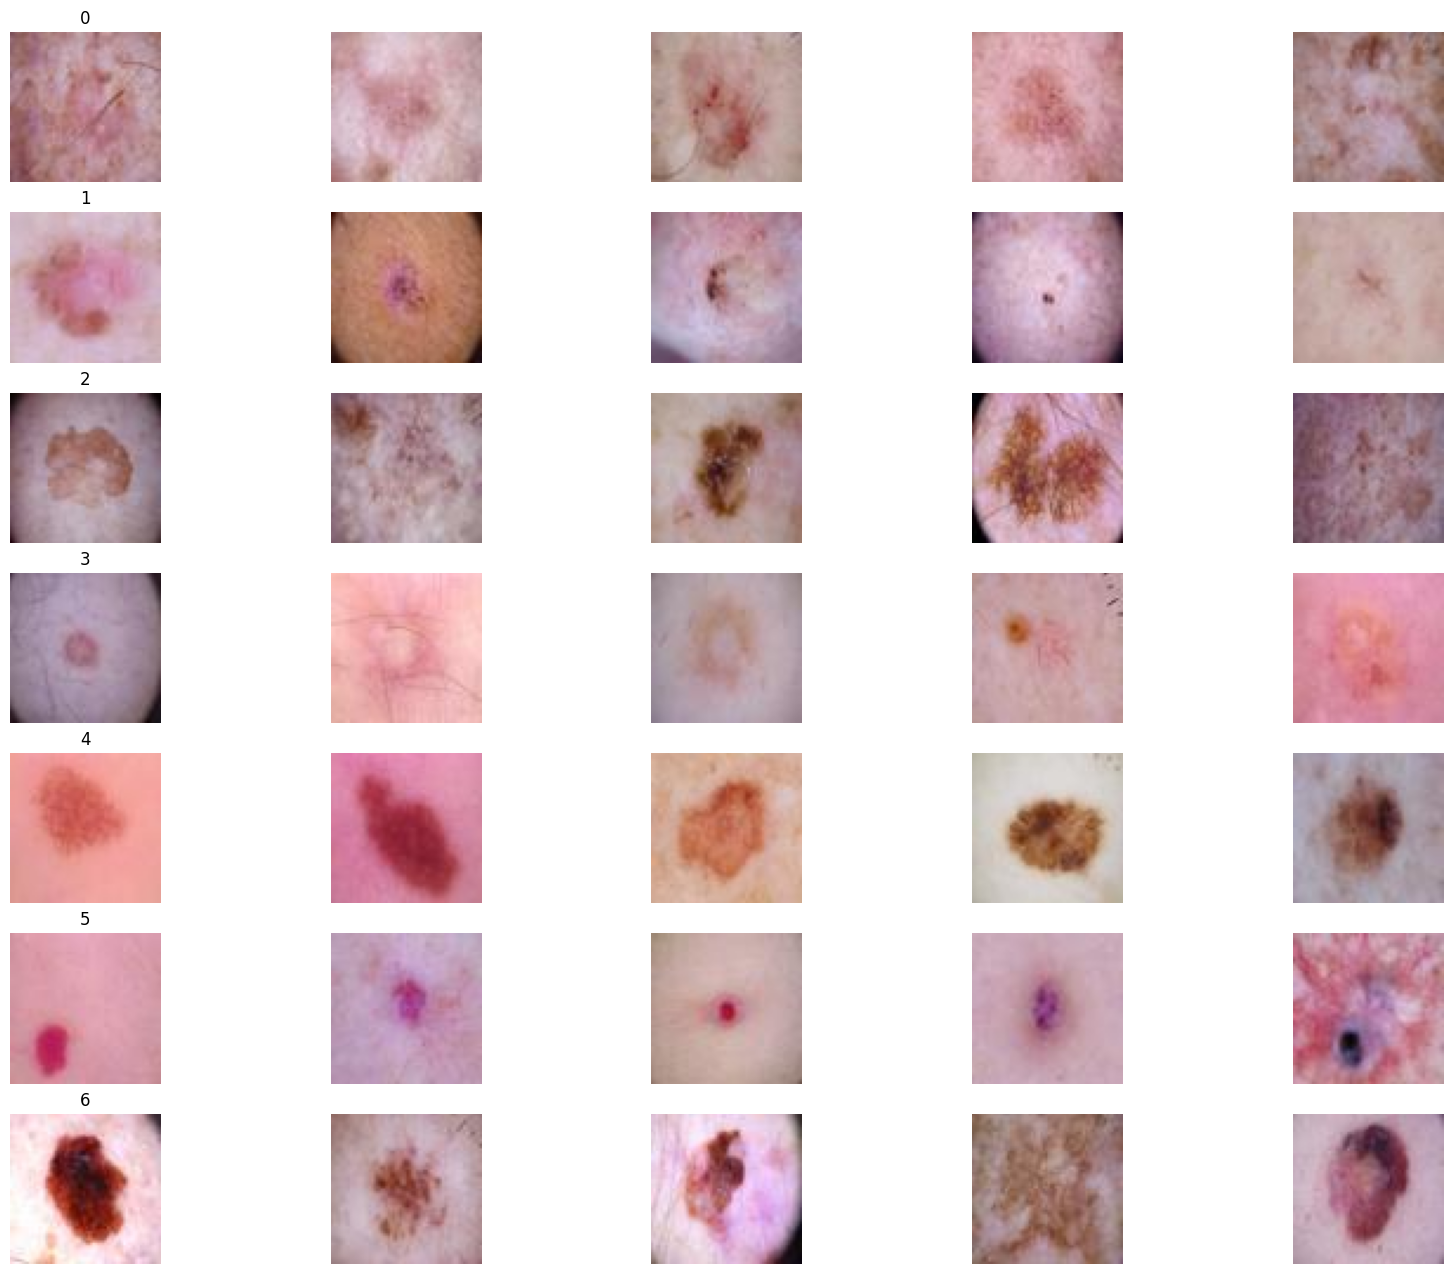

In [ ]:
import matplotlib.pyplot as plt

n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 4*4))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         skin_df.sort_values(['label']).groupby('label')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [ ]:
# 'label'열 맨 뒤로 옮기기
label_column = skin_df.pop('label')
skin_df.insert(len(skin_df.columns), 'label', label_column)

skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,image,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,None,"[[[191, 153, 190], [190, 152, 189], [192, 152,...",2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,None,"[[[20, 11, 30], [20, 11, 30], [35, 21, 44], [6...",2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,None,"[[[174, 126, 142], [186, 138, 154], [196, 145,...",2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,None,"[[[32, 6, 17], [47, 20, 29], [70, 40, 50], [91...",2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,None,"[[[149, 96, 124], [163, 110, 138], [182, 129, ...",2
...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,None,"[[[156, 139, 157], [153, 136, 154], [151, 134,...",0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,None,"[[[5, 5, 0], [7, 7, 0], [16, 11, 5], [38, 31, ...",0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,None,"[[[117, 103, 103], [141, 127, 127], [130, 114,...",0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,None,"[[[159, 118, 136], [163, 122, 140], [168, 127,...",0


# 데이터 증강 ... 데이터 부족한 애들 약 1000개로 맞춤

In [ ]:
# 이미지 증강
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.3,)

In [ ]:
# 증강 필요한 질병 데이터
vasc_df_data = skin_df[(skin_df['label'] == 3) | (skin_df['label'] == 5)]

akiec_data = skin_df[skin_df['label'] == 0]

bcc_data = skin_df[skin_df['label'] == 1]

## df랑 vasc(제일 데이터 작은 애들...100개) 10배 증강

In [ ]:
augmented_vasc_df = pd.DataFrame(columns=skin_df.columns)

for i in range(len(vasc_df_data)):
    image_row = vasc_df_data.iloc[i]
    image = image_row['image']
    other_data = image_row.drop('image')

    for j in range(10):
        augmented_image = datagen.random_transform(image)  # 이미지 증강

        augmented_metadata = other_data.copy()
        augmented_metadata['image'] = augmented_image
        augmented_vasc_df.loc[i*10 + j] = augmented_metadata

# 데이터 합치기
augmented_vasc_df = pd.concat([vasc_df_data, augmented_vasc_df], axis=0)

augmented_vasc_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,image,label
1095,HAM_0005276,ISIC_0027008,df,histo,75.0,male,back,None,"[[[156, 111, 106], [175, 130, 125], [189, 145,...",3
1096,HAM_0005276,ISIC_0028790,df,histo,75.0,male,back,None,"[[[204, 162, 176], [207, 165, 177], [217, 171,...",3
1097,HAM_0004103,ISIC_0028880,df,histo,55.0,male,lower extremity,None,"[[[218, 189, 220], [217, 188, 219], [220, 191,...",3
1098,HAM_0004103,ISIC_0031309,df,histo,55.0,male,lower extremity,None,"[[[41, 15, 24], [64, 38, 47], [97, 71, 80], [1...",3
1099,HAM_0001164,ISIC_0030021,df,histo,50.0,female,upper extremity,None,"[[[196, 153, 160], [198, 155, 162], [201, 158,...",3
...,...,...,...,...,...,...,...,...,...,...
2565,HAM_0005560,ISIC_0027269,vasc,consensus,60.0,female,trunk,None,"[[[233, 193, 204], [233, 192, 204], [233, 191,...",5
2566,HAM_0005560,ISIC_0027269,vasc,consensus,60.0,female,trunk,None,"[[[232, 189, 208], [231, 188, 207], [231, 188,...",5
2567,HAM_0005560,ISIC_0027269,vasc,consensus,60.0,female,trunk,None,"[[[246, 187, 219], [239, 189, 218], [235, 191,...",5
2568,HAM_0005560,ISIC_0027269,vasc,consensus,60.0,female,trunk,None,"[[[234, 192, 206], [233, 193, 204], [233, 192,...",5


## akiec 4배 증강 ... 327개

In [ ]:
augmented_akiec = pd.DataFrame(columns=skin_df.columns)

for i in range(len(akiec_data)):
    image_row = akiec_data.iloc[i]
    image = image_row['image']
    other_data = image_row.drop('image')

    for j in range(4):
        augmented_image = datagen.random_transform(image)  # 이미지 증강

        augmented_metadata = other_data.copy()
        augmented_metadata['image'] = augmented_image
        augmented_akiec.loc[i*4 + j] = augmented_metadata

#1308
augmented_akiec = pd.concat([akiec_data, augmented_akiec], axis=0)

## bcc 2배 증강 ... 500개

In [ ]:
augmented_bcc = pd.DataFrame(columns=skin_df.columns)

for i in range(len(bcc_data)):
    image_row = bcc_data.iloc[i]
    image = image_row['image']
    other_data = image_row.drop('image')

    for j in range(2):
        augmented_image = datagen.random_transform(image)  # 이미지 증강

        augmented_metadata = other_data.copy()
        augmented_metadata['image'] = augmented_image
        augmented_bcc.loc[i*2 + j] = augmented_metadata

# 결과 확인
augmented_bcc = pd.concat([bcc_data, augmented_bcc], axis=0)

In [ ]:
merged_df = pd.concat([skin_df , augmented_vasc_df, augmented_akiec, augmented_bcc], ignore_index=True)

merged_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,image,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,None,"[[[191, 153, 190], [190, 152, 189], [192, 152,...",2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,None,"[[[20, 11, 30], [20, 11, 30], [35, 21, 44], [6...",2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,None,"[[[174, 126, 142], [186, 138, 154], [196, 145,...",2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,None,"[[[32, 6, 17], [47, 20, 29], [70, 40, 50], [91...",2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,None,"[[[149, 96, 124], [163, 110, 138], [182, 129, ...",2
...,...,...,...,...,...,...,...,...,...,...
16014,HAM_0001215,ISIC_0031531,bcc,histo,70.0,male,back,None,"[[[177, 149, 148], [173, 145, 144], [172, 144,...",1
16015,HAM_0005026,ISIC_0028978,bcc,histo,40.0,female,abdomen,None,"[[[126, 102, 98], [150, 126, 122], [162, 138, ...",1
16016,HAM_0005026,ISIC_0028978,bcc,histo,40.0,female,abdomen,None,"[[[212, 185, 190], [212, 185, 190], [212, 185,...",1
16017,HAM_0005026,ISIC_0028728,bcc,histo,40.0,female,abdomen,None,"[[[225, 194, 202], [224, 193, 201], [224, 192,...",1


## 이미지 증강 및 데이터 합치기 끝

In [ ]:
for i in range(merged_df.shape[0]):
    merged_df.at[i, 'image'] = merged_df.at[i, 'image'].astype('float32') / 255

merged_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,image,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,None,"[[[0.7490196, 0.6, 0.74509805], [0.74509805, 0...",2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,None,"[[[0.078431375, 0.043137256, 0.11764706], [0.0...",2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,None,"[[[0.68235296, 0.49411765, 0.5568628], [0.7294...",2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,None,"[[[0.1254902, 0.023529412, 0.06666667], [0.184...",2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,None,"[[[0.58431375, 0.3764706, 0.4862745], [0.63921...",2
...,...,...,...,...,...,...,...,...,...,...
16014,HAM_0001215,ISIC_0031531,bcc,histo,70.0,male,back,None,"[[[0.69411767, 0.58431375, 0.5803922], [0.6784...",1
16015,HAM_0005026,ISIC_0028978,bcc,histo,40.0,female,abdomen,None,"[[[0.49411765, 0.4, 0.38431373], [0.5882353, 0...",1
16016,HAM_0005026,ISIC_0028978,bcc,histo,40.0,female,abdomen,None,"[[[0.83137256, 0.7254902, 0.74509805], [0.8313...",1
16017,HAM_0005026,ISIC_0028728,bcc,histo,40.0,female,abdomen,None,"[[[0.88235295, 0.7607843, 0.7921569], [0.87843...",1


In [ ]:
inputs = merged_df[['age', 'sex', 'localization', 'image']]
labels= merged_df['label']

type(inputs)

pandas.core.frame.DataFrame

## 순서 섞기

In [ ]:
# DataFrame을 NumPy 배열로 변환
inputs_np = inputs.values

# 배열의 인덱스를 무작위로 섞음
idx = np.random.permutation(len(inputs_np))

# 섞인 인덱스를 사용하여 배열을 섞음
inputs, labels = inputs_np[idx], labels[idx]

type(inputs)

numpy.ndarray

In [ ]:
inputs[0][3].shape

(64, 64, 3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.3,random_state=42)

y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

In [ ]:
# 이미지 입력 레이어
image_input = Input(shape=(64, 64, 3), name='image_input')

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
conv1 = BatchNormalization()(conv1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)  # 추가된 합성곱 층
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)  # 추가된 합성곱 층
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)  # 추가된 합성곱 층
conv3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D((2, 2))(conv3)

image = Flatten()(pool3)

# 나이 입력 레이어
age_input = Input(shape=(1,), name='age_input')

# 성별 입력 레이어
sex_input = Input(shape=(3,), name='sex_input')

# 발병 위치 입력 레이어
localization_input = Input(shape=(15,), name='localization_input')

# 멀티인풋 생성
multi_input = concatenate([image, age_input, sex_input, localization_input])

# 완전 연결층
dense1 = Dense(512, activation='relu')(multi_input)
dropout1 = Dropout(0.5)(dense1)
batchnorm1 = BatchNormalization()(dropout1)

dense2 = Dense(256, activation='relu')(batchnorm1)
dropout2 = Dropout(0.5)(dense2)
batchnorm2 = BatchNormalization()(dropout2)

# 출력 레이어 (다중 클래스 분류)
output = Dense(7, activation='softmax')(batchnorm2)  # 7가지 질병 중 하나 예측

# 모델 생성
model = Model(inputs=[image_input, age_input, sex_input, localization_input], outputs=output)

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 요약 출력
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_15 (Conv2D)          (None, 64, 64, 32)           896       ['image_input[0][0]']         
                                                                                                  
 batch_normalization_19 (Ba  (None, 64, 64, 32)           128       ['conv2d_15[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_16 (Conv2D)          (None, 64, 64, 32)           9248      ['batch_normalization_19

In [ ]:
X_train_image = X_train[:, 3]
X_train_age = X_train[:, 0]
X_train_sex = X_train[:, 1]
X_train_localization = X_train[:, 2]

X_test_image = X_test[:, 3]
X_test_age = X_test[:, 0]
X_test_sex = X_test[:, 1]
X_test_localization = X_test[:, 2]

# y_train을 원-핫 인코딩
y_train_encoded = to_categorical(y_train, num_classes=7)

print(type(X_train_image))
print(type(X_train_age))
print(type(X_train_sex))
print(type(X_train_localization))
print(type(y_train_encoded))
print(X_train_sex.shape)
print(X_test_sex.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(11213,)
(4806,)


In [ ]:
label_encoder_sex = LabelEncoder()
onehot_encoder_sex = OneHotEncoder()

train_labels_sex = label_encoder_sex.fit_transform(X_train_sex)
X_train_sex_one_hot = onehot_encoder_sex.fit_transform(train_labels_sex.reshape(-1, 1))

test_labels_sex = label_encoder_sex.fit_transform(X_test_sex)
X_test_sex_one_hot = onehot_encoder_sex.fit_transform(test_labels_sex.reshape(-1, 1))

print(X_train_sex_one_hot.shape)
print(X_test_sex_one_hot.shape)

(11213, 3)
(4806, 3)


In [ ]:
label_encoder_localization = LabelEncoder()
onehot_encoder_localization = OneHotEncoder()

localization_train_labels = label_encoder_localization.fit_transform(X_train_localization)
X_train_localization_one_hot = onehot_encoder_localization.fit_transform(localization_train_labels.reshape(-1, 1))

localization_test_labels = label_encoder_localization.fit_transform(X_test_localization)
X_test_localization_one_hot = onehot_encoder_localization.fit_transform(localization_test_labels.reshape(-1, 1))

print(X_train_localization_one_hot.shape)
print(X_test_localization_one_hot.shape)

(11213, 15)
(4806, 15)


In [ ]:
# 이미지 데이터를 넘파이 배열로 변환
X_train_image_np = np.array([np.array(image) for image in X_train_image])
X_test_image_np = np.array([np.array(image) for image in X_test_image])

X_train_age_np = np.array([np.array(age) for age in X_train_age])
X_test_age_np = np.array([np.array(age) for age in X_test_age])

X_train_sex_one_hot_np = X_train_sex_one_hot.toarray()
X_test_sex_one_hot_np = X_test_sex_one_hot.toarray()

X_train_localization_one_hot_np = X_train_localization_one_hot.toarray()
X_test_localization_one_hot = X_test_localization_one_hot.toarray()

In [ ]:
# 모델을 훈련시킴
history = model.fit([X_train_image_np, X_train_age_np, X_train_sex_one_hot_np, X_train_localization_one_hot_np], y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/50
281/281 [==============================] - 11s 25ms/step - loss: 1.4505 - accuracy: 0.4940 - val_loss: 2.6876 - val_accuracy: 0.1235
Epoch 2/50
281/281 [==============================] - 5s 18ms/step - loss: 1.1822 - accuracy: 0.5668 - val_loss: 1.0357 - val_accuracy: 0.6130
Epoch 3/50
281/281 [==============================] - 5s 20ms/step - loss: 1.0576 - accuracy: 0.6067 - val_loss: 0.9725 - val_accuracy: 0.6179
Epoch 4/50
281/281 [==============================] - 6s 20ms/step - loss: 0.9509 - accuracy: 0.6470 - val_loss: 0.9705 - val_accuracy: 0.6322
Epoch 5/50
281/281 [==============================] - 5s 19ms/step - loss: 0.9258 - accuracy: 0.6585 - val_loss: 1.0819 - val_accuracy: 0.5867
Epoch 6/50
281/281 [==============================] - 6s 21ms/step - loss: 0.9000 - accuracy: 0.6671 - val_loss: 0.9163 - val_accuracy: 0.6714
Epoch 7/50
281/281 [==============================] - 5s 19ms/step - loss: 0.9638 - accuracy: 0.6337 - val_loss: 0.8460 - val_accuracy: 0.677

In [ ]:
loss, acc = model.evaluate([X_test_image_np, X_test_age_np, X_test_sex_one_hot_np, X_test_localization_one_hot], y_test, verbose=1)

print("테스트 세트 손실:", loss)
print("테스트 세트 정확도:", acc)

151/151 [==============================] - 1s 8ms/step - loss: 0.8770 - accuracy: 0.7303
테스트 세트 손실: 0.8770014643669128
테스트 세트 정확도: 0.7303370833396912
